## Deploy Notebook Function

by: Alex Comerford (alexanderjcomerford@gmail.com)

In this notebook we will guide the user through the steps to deploying a jupyter notebook as a serverless function on openfaas.

### Setup

First we will setup the openfaas cli and environment variables to allow us to directly talk to openfaas.

In [4]:
## Install the openfaas cli
!curl -sL https://cli.openfaas.com | sh

## Setup openfaas url for deployment    
%env OPENFAAS_URL=gateway-external.openfaas.svc.cluster.local:8080


You already have the faas-cli!
Overwriting in 1 seconds.. Press Control+C to cancel.

x86_64
Download complete.

Running as root - Attempting to move faas-cli to /usr/local/bin
New version of faas-cli installed to /usr/local/bin
  ___                   _____           ____
 / _ \ _ __   ___ _ __ |  ___|_ _  __ _/ ___|
| | | | '_ \ / _ \ '_ \| |_ / _` |/ _` \___ \
| |_| | |_) |  __/ | | |  _| (_| | (_| |___) |
 \___/| .__/ \___|_| |_|_|  \__,_|\__,_|____/
      |_|

CLI:
 commit:  a141dedf94ffeed84412365fd591bdc8999c5a1b
 version: 0.8.3
env: OPENFAAS_URL=gateway-external.openfaas.svc.cluster.local:8080


### Deploying a notebook

There are only two requirements to deploy a notebook as a function in openfaas

1. Write a jupyter notebook 
2. Deploy the 

In [5]:
import os
def deploy_notebook(NOTEBOOK_NAME):
    
    funcname=os.path.splitext(
        os.path.basename(NOTEBOOK_NAME))[0].lower().replace("_","-")

    !./faas-cli build --image={funcname} \
                      --handler=./       \
                      --lang=dockerfile  \
                      --parallel=4       \
                      --no-cache         \
                      --name={funcname}  \
                      --build-arg notebook={NOTEBOOK_NAME} \
                      > /dev/null 2>&1

    !./faas-cli deploy --image={funcname} \
                       --name={funcname}

## Test example stdout notebooks

In the next cell we will test (with curl) a notebook that outputs application/json to a file and output it to a file, then print that files json contents 

In [3]:
%%time
deploy_notebook("./notebook_out_test.ipynb")


Deployed. 202 Accepted.
URL: http://gateway-external.openfaas.svc.cluster.local:8080/function/notebook-out-test

CPU times: user 464 ms, sys: 101 ms, total: 565 ms
Wall time: 32.4 s


In [5]:
!curl $OPENFAAS_URL/function/notebook-out-test

hello i am stdout!



## Test example mime-type output notebooks

In the next cell we will test (with curl) a notebook that outputs different mime-types to a file and output it to a file, then print that files json contents 

In [6]:
%%time
deploy_notebook("./notebook_multiple_outputs.ipynb")


Deployed. 202 Accepted.
URL: http://gateway-external.openfaas.svc.cluster.local:8080/function/notebook-multiple-outputs

CPU times: user 478 ms, sys: 117 ms, total: 595 ms
Wall time: 33.1 s


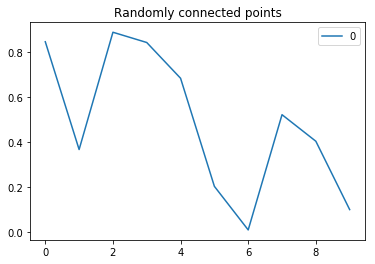

CPU times: user 87.8 ms, sys: 24.7 ms, total: 112 ms
Wall time: 6.7 s


In [8]:
%%time

## Get a new plot updating the number of points we want
!curl -s -o /tmp/notebook-multiple-outputs \
      --data '{"NUM_POINTS":10}' \
      -H "Content-Type: application/json" \
      -H "Accept: image/png" \
      $OPENFAAS_URL/function/notebook-multiple-outputs

## Decode the b64 plot to a png
!cat /tmp/notebook-multiple-outputs | base64 -d > /tmp/decoded.png

## Display the decoded image
from IPython.display import display, Image
display(Image(filename='/tmp/decoded.png'))

In [10]:
%%time

## Get a new plot updating the number of points we want
out = !curl -s \
      --data '{"TEST":"Hello i am a test string!"}' \
      -H "Content-Type: application/json" \
      -H "Accept: application/json" \
      $OPENFAAS_URL/function/notebook-multiple-outputs

from IPython.display import display, JSON
display(JSON(out))

<IPython.core.display.JSON object>

CPU times: user 1.48 ms, sys: 4.88 ms, total: 6.36 ms
Wall time: 5.94 s


## Cosine Similarity in scala example

In the next cell we will deploy a notebook written in scala as a function and get the cosine similarity as an output

In [9]:
%%time
deploy_notebook("./notebook_cosine_similarity_scala.ipynb")


Deployed. 202 Accepted.
URL: http://gateway-external.openfaas.svc.cluster.local:8080/function/notebook-cosine-similarity-scala

CPU times: user 517 ms, sys: 135 ms, total: 652 ms
Wall time: 34.4 s


In [12]:
%%time

## Get a new plot updating the number of points we want
!curl -s \
      --data '{"VECTOR_A":[1,-2,3,1,-1,1,-1,5,5,5,-5,5,5],  \
               "VECTOR_B":[1,1, 4,1, 1,1, 1,5,5,5, 5,5,5]}' \
      -H "Content-Type: application/json" \
      -H "Accept: text/plain" \
      $OPENFAAS_URL/function/notebook-cosine-similarity-scala

0.6529863674023287
CPU times: user 171 ms, sys: 24 ms, total: 195 ms
Wall time: 11.4 s
